# Building a Robot Judge: Exercise 1

## 0. Load Data

In [2]:
import pandas as pd

In [3]:
# load data
cases_path = "../data/cases/"
cases_list_path = "../data/case_reversed.csv"
num_keep = 1000
saved_doc_filename = "cases_with_doc_{}.pkl".format(num_keep)
cases = pd.read_csv(cases_list_path)
cases.head() # print first few elements

caseid  case_reversed
0  X3JGGO              0
1  X3OH3J              0
2  X3U0KO              0
3  X53HAD              0
4  X9VC5V              0

In [4]:
# subsample 1000 cases
from random import shuffle
keep_idxs = [True] * num_keep + [False] * (len(cases) - num_keep)
shuffle(keep_idxs)
cases = cases[keep_idxs]

In [5]:
# load the case documents
import glob
import os
for index, row in cases.iterrows():
    case_file = glob.glob("{}*_{}.txt".format(cases_path, row['caseid']))[0] # assumes there is only one file with this id
    with open(case_file, 'r', encoding='utf8') as f:
        cases.at[index, 'text'] = f.read()
        cases.at[index, 'year'] = int(os.path.splitext(os.path.basename(case_file))[0].split('_')[0])
cases.head()

caseid  case_reversed                                               text  \
6   X9VC5U              0   PER CURIAM.\nMcCarver was a (so-called) narco...   
10  X3IURJ              0   PER CURIAM.\nOn receipt of the mandate of thi...   
30  X3BD9F              0   PAGE , Circuit Judge.\nAppellant, incorporate...   
34  X3T4I2              0   ROBB , Associate Justice.\nAppeal from a judg...   
41  X9UE16              0   ANDERSON , Circuit Judge.\nThis is an appeal ...   

      year  
6   1925.0  
10  1925.0  
30  1926.0  
34  1925.0  
41  1926.0

## 1. Split the documents into sentences and tokens.
### Use spaCy to process all cases. Split the documents into sentences and tokens. Compute number of sentences, words, and letters for each document. Report histograms for these statistics.

#### Run nlp or load precomputed documents

In [6]:
import os
# if we have the doc already computed -> load from file
if os.path.exists(saved_doc_filename):
    cases = pd.read_pickle(saved_doc_filename)
else:
    # load spacy english model
    import spacy
    nlp = spacy.load('en')

    # get spacy documents for each case and add to dataframe
    def run_spacy(txt):
        return nlp(txt)
    
    cases['doc'] = cases['text'].apply(run_spacy)

    # this will come in handy for later, so save it:
    cases.to_pickle(saved_doc_filename)

#### Compute number of sentences, words and letters

In [7]:
def get_num_sentences(doc):
    ''' return number of sentences from spacy document '''
    return len(list(doc.sents))

def get_num_words(doc):
    ''' return number of words from spacy document
        everything that consists of alphabetic characters (no numbers (digits), no punctuation etc) '''
    return len([token for token in doc if token.is_alpha])

def get_num_tokens(doc):
    return len(list(doc)) # can also consider eacch token a word

cases['num_sentences'] = cases['doc'].apply(get_num_sentences)
cases['num_tokens'] = cases['doc'].apply(get_num_tokens)
cases['num_words'] = cases['doc'].apply(get_num_words)
cases['num_letters'] = cases['text'].str.len() # use pandas built-in, this is not very exact as it also contains punctuation, numbers etc.

print("Total: {} sentences, {} tokens, {} words, {} letters".format(cases['num_sentences'].sum(), cases['num_tokens'].sum(), cases['num_words'].sum(), cases['num_letters'].sum()))
cases[['num_sentences', 'num_words', 'num_letters']].head()

Total: 159490 sentences, 3887901 tokens, 2910170 words, 19554680 letters


num_sentences  num_words  num_letters
3             213       5236        33141
5              12        197         1258
14            149       4185        25586
16             57       2971        17586
19             91       2951        17483

In [8]:
# plot histogram
import numpy
import matplotlib.pyplot as plt

num_bins = 20
fig = plt.figure()

ax_sentences = cases.hist(column=['num_sentences'], bins=num_bins)[0]
ax_tokens = cases.hist(column=['num_tokens'], bins=num_bins)[0]
ax_words = cases.hist(column=['num_words'], bins=num_bins)[0]
ax_letters = cases.hist(column=['num_letters'], bins=num_bins)[0]
# if we do all columns in one call we cannot control the order of the plots
#ax_sentences, ax_words, ax_letters = cases.hist(column=['num_sentences', 'num_words', 'num_letters'], bins=num_bins, figsize=(15, 15), layout=(3, 1))

ax_sentences[0].set_xlabel("Number of sentences")
ax_sentences[0].set_ylabel("Frequency")
ax_tokens[0].set_xlabel("Number of tokens")
ax_tokens[0].set_ylabel("Frequency")
ax_words[0].set_xlabel("Number of words")
ax_words[0].set_ylabel("Frequency")
ax_letters[0].set_xlabel("Number of letters")
ax_letters[0].set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

## 2. Count the number of nouns, verbs and adjectives
### Use the spaCy parts of speech (POS) tags to count number of nouns, verbs, and adjectives in each document. Visualize POS frequency by year.

In [9]:
# load the precomputed doc
if not 'doc' in cases.columns:
    cases = pd.read_pickle(saved_doc_filename)

Text(0, 0.5, 'Count')

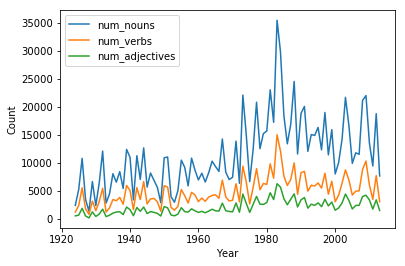

In [10]:
# count nouns, verbs and adjectives

def count_nouns(doc):
    return len([token for token in doc if token.tag_.startswith('N')])

def count_adjectives(doc):
    return len([token for token in doc if token.tag_.startswith('J')])

def count_verbs(doc):
    return len([token for token in doc if token.tag_.startswith('V')])

cases['num_nouns'] = cases['doc'].apply(count_nouns)
cases['num_verbs'] = cases['doc'].apply(count_verbs)
cases['num_adjectives'] = cases['doc'].apply(count_adjectives)

cases[['num_nouns', 'num_verbs', 'num_adjectives']].head()

# compoute number of nouns, verbs and adjectives per year
ax = cases.groupby('year')[['num_nouns', 'num_verbs', 'num_adjectives']].sum().plot()
ax.set_xlabel("Year")
ax.set_ylabel("Count")

## 3. Normalize Data
### Follow the steps in lecture to normalize your corpus (e.g., removing punctuation) and discuss your choices about what information to exclude. Using the normalized tokens, make a feature set of all trigrams that end in a noun.

In [11]:
# lead the precomputed doc
if not 'doc' in cases.columns:
    cases = pd.read_pickle(saved_doc_filename)
    

#### Normalizing the data:
#### Tokens such as new line, whitespaces, punctuation and stopwords do not contain useful information. Therefore we just discard those.
#### Words can sometimes contain captial letters and sometimes not, or for example abbreviations might have dots or not (e.g. US vs U.S.), but there is no distinction in meaning. To normalize those we convert everything to lowercase and remove punctiations.
#### Then there can be several variations of a word with the same meaning (e.g. conjugation, past tense etc.), which we want to merge into a single representation. For this we can use a stemmer or lemmatizer. In this case we used a lemmatizer.
#### Also for numbers we don't care about the actual value and thus replace it with '#'

In [12]:
# normalize tokens

from string import punctuation
translator = str.maketrans('','',punctuation) # maps punctuations to None

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english')) # unimportant words like the, an, at, for etc.

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english') # extracts word stem (currently use token.lemma_ instead of stemmer)

def normalize_doc(doc):
    ''' Input spacy doc and return clean list of normalized tokens (word, token)-pair (so we still have tagging info) '''
    tokens = []    
    for sent in doc.sents:  
        for token in sent:
            # discard non informative tokens:
            #   'new line' (whitespaces) -> token.is_space
            #   pure punctuation -> token.is_punct
            #   stop words -> token.is_stop or word in stoplist (in case stoplist contains mroe words)

            # simplify strings: 
            #   lemma (better than wordstem) -> token.lemma_
            #   lowercase -> str.lower()
            #   remove punctuation that are part of words (e.g. U.S.) -> str.translate(translator)
            #   replace digits with '#' -> token.isdigit()

            word = token.lemma_.lower().translate(translator)    
            if word.isdigit(): # token.is_digit only works for whole numbers, like_num also includes spelled out numbers (which we could also think of discarding)
                word = "#" 
            discard_token = token.is_space or token.is_punct or token.is_stop or word in stoplist
    
            if not discard_token:
                tokens.append((word, token))
        
    return tokens

cases['tokens_normalized'] = cases['doc'].apply(normalize_doc)
cases['tokens_normalized'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3     [(rogers, ROGERS), (circuit, Circuit), (judge,...
5     [(per, PER), (curiam, CURIAM), (collector, col...
14    [(bingham, BINGHAM), (circuit, Circuit), (judg...
16    [(ross, ROSS), (circuit, Circuit), (judge, Jud...
19    [(gibson, GIBSON), (district, District), (judg...
Name: tokens_normalized, dtype: object

#### Find all trigrams that end in a noun

In [13]:
from nltk import ngrams

def make_trigrams(normalized_word_token_pairs):
    trigrams = ngrams(normalized_word_token_pairs, 3)
    trigrams_ending_with_noun = [trigram for trigram in trigrams if trigram[2][1].tag_.startswith('N')] # trigram[2][1] = token of third element
    trigrams_joined = ['_'.join([word for word, _ in trigram]) for trigram in trigrams_ending_with_noun]
    return trigrams_joined

cases['trigrams'] = cases['tokens_normalized'].apply(make_trigrams)
cases['trigrams'].head()

3     [rogers_circuit_judge, circuit_judge_complaina...
5     [per_curiam_collector, collector_internal_reve...
14    [bingham_circuit_judge, circuit_judge_defendan...
16    [ross_circuit_judge, circuit_judge_number, num...
19    [gibson_district_judge, district_judge_court, ...
Name: trigrams, dtype: object

## 4. Frequencies over trigrams ending in a noun
### Make a dataframe with at least 1000 features (frequencies over trigrams ending in a noun). Standardize the features to variance one while maintaining sparsity. 

In [14]:
# compute the frequency of each trigram ending in a nound

from collections import Counter
trigram_frequencies = Counter()

for trigrams in cases['trigrams']:
    trigram_frequencies.update(trigrams)

trigram_frequencies
trigram_frequencies.most_common()[:10]

[('#_#_sct', 9093),
 ('#_#_led2d', 4417),
 ('#_#_led', 2490),
 ('v_united_states', 1646),
 ('deny_#_us', 878),
 ('#_united_states', 679),
 ('#_#_l', 670),
 ('states_#_us', 645),
 ('cir_#_f2d', 645),
 ('#_district_court', 608)]

#### Make a dataset with 1000 featuers (frequencies of trigrams ending in a nound)

In [15]:
# count the trigrams in all cases
frequencies = []
for trigrams in cases['trigrams']:
    frequencies.append(Counter(trigrams)) # make a counter for each row
    
all_features = pd.DataFrame(frequencies) # new dataframe with the frequency features
all_features.fillna(0, inplace=True) # replace NaN with 0
all_features.head()

#_#_#  #_#_029th  #_#_101st  #_#_109th  #_#_11th  #_#_156a  #_#_16th  \
0    0.0        0.0        0.0        0.0       0.0       0.0       0.0   
1    0.0        0.0        0.0        0.0       0.0       0.0       0.0   
2    0.0        0.0        0.0        0.0       0.0       0.0       0.0   
3    0.0        0.0        0.0        0.0       0.0       0.0       0.0   
4    0.0        0.0        0.0        0.0       0.0       0.0       0.0   

   #_#_1st  #_#_2000e  #_#_21201f2           ...             \
0      0.0        0.0          0.0           ...              
1      0.0        0.0          0.0           ...              
2      0.0        0.0          0.0           ...              
3      0.0        0.0          0.0           ...              
4      0.0        0.0          0.0           ...              

   →_reasonable_person  □_#_percent  □_competitive_equity  \
0                  0.0          0.0                   0.0   
1                  0.0          0.0                   0.0   
2                  0.0          0.0                   0.0   
3                  0.0          0.0                   0.0   
4                  0.0          0.0                   0.0   

   □_disposal_treatment  □_electric_power  □_entity_transmission  □_overt_act  \
0                   0.0               0.0                    0.0          0.0   
1                   0.0               0.0                    0.0          0.0   
2                   0.0               0.0                    0.0          0.0   
3                   0.0               0.0                    0.0          0.0   
4                   0.0               0.0                    0.0          0.0   

   □_principle_institution  □_propose_□  □_transporter_transport  
0                      0.0          0.0                      0.0  
1                      0.0          0.0                      0.0  
2                      0.0          0.0                      0.0  
3                      0.0          0.0                      0.0  
4                      0.0          0.0                      0.0  

[5 rows x 796254 columns]

In [16]:
# use the 1000 most common trigrams -> use those for vocabulary
vocab = [x[0] for x in trigram_frequencies.most_common()[:1000]]

features = all_features[vocab] # keep only the features for the specified trigrams (most common)
features.to_pickle("features_{}.pkl".format(num_keep))

#### Standardize the features but keep it sparse

In [17]:
#mean = features.mean()
std = features.std()
#features = (features - mean) / std
features /= std # data is sparse -> only scale it to unit variance, but don't shift (would destroy sparsity)
features.head()

#_#_sct  #_#_led2d  #_#_led  v_united_states  deny_#_us  #_united_states  \
0      0.0        0.0      0.0          0.00000        0.0              0.0   
1      0.0        0.0      0.0          0.00000        0.0              0.0   
2      0.0        0.0      0.0          3.50124        0.0              0.0   
3      0.0        0.0      0.0          0.00000        0.0              0.0   
4      0.0        0.0      0.0          0.00000        0.0              0.0   

      #_#_l  states_#_us  cir_#_f2d  #_district_court           ...            \
0  6.108267          0.0        0.0               0.0           ...             
1  0.000000          0.0        0.0               0.0           ...             
2  4.720024          0.0        0.0               0.0           ...             
3  0.000000          0.0        0.0               0.0           ...             
4  0.000000          0.0        0.0               0.0           ...             

   term_condition_employment  wholly_owned_subsidiary  tort_claims_act  \
0                        0.0                      0.0              0.0   
1                        0.0                      0.0              0.0   
2                        0.0                      0.0              0.0   
3                        0.0                      0.0              0.0   
4                        0.0                      0.0              0.0   

   violate_fourth_amendment  petition_district_court  \
0                       0.0                      0.0   
1                       0.0                      0.0   
2                       0.0                      0.0   
3                       0.0                      0.0   
4                       0.0                      0.0   

   accordingly_district_court  trade_commission_act  v_general_motors  \
0                         0.0                   0.0               0.0   
1                         0.0                   0.0               0.0   
2                         0.0                   0.0               0.0   
3                         0.0                   0.0               0.0   
4                         0.0                   0.0               0.0   

   #_rivers_harbors  court_summary_judgment  
0               0.0                     0.0  
1               0.0                     0.0  
2               0.0                     0.0  
3               0.0                     0.0  
4               0.0                     0.0  

[5 rows x 1000 columns]

## 5. Train a LogisticRegression model
### Link the dataframe to the outcome reverse. Create a training set and test set. Train a LogisticRegression model with default parameters to predict reversal. Compute accuracy and F1 for the prediction in the training set and in the test set. 


In [2]:
# create training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, cases['case_reversed'], test_size=0.2)

NameError: name 'features' is not defined

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly clos

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly clos

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly clos

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly clos

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Dominik\Anaconda3\envs\RJ\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly clos

In [19]:
# train logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
print("Training score: {}".format(log_reg.score(x_train, y_train)))

C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score: 0.98375


[Training Set] Accuracy: 0.984, F1: 0.987, (Precision: 0.975, Recall: 1.000)
[Test Set] Accuracy: 0.540, F1: 0.629, (Precision: 0.645, Recall: 0.614)


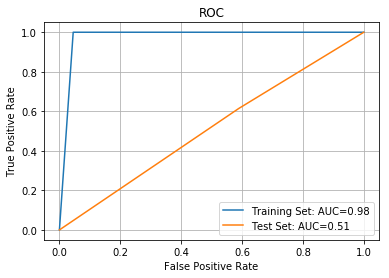

In [20]:
# predict
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc

def prediction_score(x, y, model, prefix):
    pred = model.predict(x)
    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)
    print("[{}] Accuracy: {:0.3f}, F1: {:0.3f}, (Precision: {:0.3f}, Recall: {:0.3f})".format(prefix, acc, f1, prec, rec))
    
    fpr, tpr, thresholds = roc_curve(y, pred)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC={:0.2f}'.format(prefix, area))
    plt.grid(True)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
prediction_score(x_train, y_train, log_reg, "Training Set")
prediction_score(x_test, y_test, log_reg, "Test Set") 


## 6. GridSearchCV to choose hyperparameters
### Use GridSearchCV() to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C. Report the best model parameters and score. Report the ROC Curve and AUC.

In [21]:
# grid search to find parameters
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, parameters, n_jobs=-1)
grid.fit(x_train, y_train)


C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Dominik\Anaconda3\envs\RJ\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ('l1', 'l2'), 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### There seems to be something wrong with the GridSearch as the found best parameters is always worse than the default parameters.

[Grid Search Result] Best Parameters: Penalty: l2, Regularization C: 0.0001
[Training Set (GridSearch)] Accuracy: 0.664, F1: 0.790, (Precision: 0.658, Recall: 0.988)
[Test Set (GridSearch)] Accuracy: 0.620, F1: 0.759, (Precision: 0.635, Recall: 0.945)


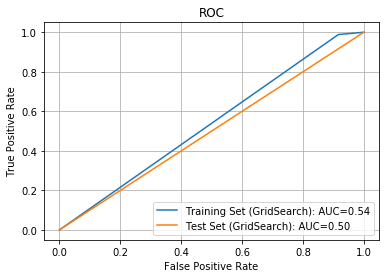

In [22]:
# get the best parameters and evaluate model

best_penalty = grid.best_params_['penalty']
best_C = grid.best_params_['C']

print("[Grid Search Result] Best Parameters: Penalty: {}, Regularization C: {}".format(best_penalty, best_C))

prediction_score(x_train, y_train, grid, "Training Set (GridSearch)")
prediction_score(x_test, y_test, grid, "Test Set (GridSearch)")

## 7. Compute vader compound sentiment scores for each sentence
### Make a new dataframe where each sentence (of each case) is treated as a separate document. Compute vader compound sentiment scores for each sentence and report the top 10 highest- and lowest-sentiment sentences.

In [22]:
# create dataframe with sentences
all_sentences = []
for doc in cases['doc']:
    for sent in doc.sents:
        text = sent.text
        text = text.replace('\r', ' ').replace('\n', ' ') # remove new line characters, no other normalization for this task
        all_sentences.append(text)
        
sentences = pd.DataFrame()
sentences['text'] = all_sentences
sentences.head()

text
0                                       PER CURIAM. 
1  The collector of internal revenue for the Fift...
2  This tax resulted from the government's theory...
3                                 St. 1918, 6336h). 
4  In its return for the year 1917, the insurance...

#### Compute vader sentiment scores

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def compute_vader(sentence):
    return sid.polarity_scores(sentence)

sentences['sentiment'] = sentences['text'].apply(compute_vader)
sentences['pos'] = [sent['pos'] for sent in sentences['sentiment']]
sentences['neu'] = [sent['neu'] for sent in sentences['sentiment']]
sentences['neg'] = [sent['neg'] for sent in sentences['sentiment']]
sentences['compound'] = [sent['compound'] for sent in sentences['sentiment']]
sentences.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\borerdo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


text  \
0                                       PER CURIAM.    
1  The collector of internal revenue for the Fift...   
2  This tax resulted from the government's theory...   
3                                 St. 1918, 6336h).    
4  In its return for the year 1917, the insurance...   

                                           sentiment    pos    neu    neg  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   
1  {'neg': 0.146, 'neu': 0.746, 'pos': 0.108, 'co...  0.108  0.746  0.146   
2  {'neg': 0.0, 'neu': 0.958, 'pos': 0.042, 'comp...  0.042  0.958  0.000   
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.000  1.000  0.000   
4  {'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...  0.064  0.936  0.000   

   compound  
0     0.000  
1    -0.250  
2     0.128  
3     0.000  
4     0.128

#### Retrieve highest- and lowest-sentiment sentences

In [24]:
num = 10
highest = sentences.sort_values(by=['pos'], ascending=False).head(num)
lowest = sentences.sort_values(by=['neg'], ascending=False).head(num)
    
print("Highest sentiment scores:")
for idx, (text, score) in enumerate(zip(highest['text'], highest['pos'])):
    print("\t {}. {} (Positive score: {})".format(idx + 1, text, score))
    
print()

print("Lowest sentiment scores:")
for idx, (text, score) in enumerate(zip(lowest['text'], lowest['neg'])):
    print("\t {}. {} (Negative score: {})".format(idx + 1, text, score))
    

Highest sentiment scores:
	 1. Yes.  (Positive score: 1.0)
	 2. Super.  (Positive score: 1.0)
	 3. Security (Positive score: 1.0)
	 4. PARADISE I (Positive score: 1.0)
	 5. Satisfied?  (Positive score: 1.0)
	 6. Okay.  (Positive score: 1.0)
	 7. 143 . (Positive score: 1.0)
	 8. Okay.  (Positive score: 1.0)
	 9. Okay.  (Positive score: 1.0)
	 10. Super.  (Positive score: 1.0)

Lowest sentiment scores:
	 1. No. (Negative score: 1.0)
	 2. No (Negative score: 1.0)
	 3. No. (Negative score: 1.0)
	 4. Exhaustion (Negative score: 1.0)
	 5. No (Negative score: 1.0)
	 6. 182 (Negative score: 1.0)
	 7. No. (Negative score: 1.0)
	 8. Injustice (Negative score: 1.0)
	 9. No (Negative score: 1.0)
	 10. No (Negative score: 1.0)


## 8. Tf-idf frequencies and cosine similarities
### Use TfidfVectorizer to compute tf-idf frequencies for each sentence, and then compute cosine similarities between all sentences. Report example pairs of very similar sentences and very dissimilar sentences. 

#### Compute Tfidf features

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.001, # at min .1% of docs
                        max_df=0.5,  # at most 50% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(2,3))

Tfidf = tfidf.fit_transform(sentences['text'])

#### Compute cosine similarity

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(Tfidf, dense_output=False)
sims.shape

(166883, 166883)

#### Find similar and dissimilar sentences

In [32]:
import numpy as np
import random
num_sents = 10
num_sentences = sims.shape[0]

print("Similar sentences:")
similar_found = 0
while similar_found < num_sents:
    idx0 = random.randint(0, num_sentences - 1)
    idx1 = random.randint(0, num_sentences - 1)
    if idx0 == idx1:
        continue
            
    if sims[idx0, idx1] > 0.9:
        sent0 = sentences['text'].iloc[idx0]
        sent1 = sentences['text'].iloc[idx1]
        print("\t{}".format(sent0))
        print("\t{}".format(sent1))
        print()
        similar_found += 1
        
print("\n---------------------------------------------------------------------------------\n")
print("Dissimilar sentences:")
similar_found = 0
while similar_found < num_sents:
    idx0 = random.randint(0, num_sentences - 1)
    idx1 = random.randint(0, num_sentences - 1)
    if idx0 == idx1:
        continue
            
    if sims[idx0, idx1] < 0.1:
        sent0 = sentences['text'].iloc[idx0]
        sent1 = sentences['text'].iloc[idx1]
        print("\t{}".format(sent0))
        print("\t{}".format(sent1))
        print()
        similar_found += 1
        

Similar sentences:
	It does not protect "inhabitants", but only "any citizen in the free exercise or enjoyment of any right or privilege secured to him by the Constitution or laws of the United States". 
	not less than the wages prevailing in the locality of the Project, as predetermined by the Secretary of Labor of the United States.

	Brooklyn City R. Co. v. New York , 199 U. S. 48, 52 , 25 S. Ct.
	Treating the case as a potential violation of both the ADEA and New York State Human Rights Law, the DHR assigned it to a human rights specialist, who issued an investigative report on October 5, 1982 and on November 29, 1982 conducted a hearing, attended by all parties and counsel, at which the witnesses of each party gave sworn testimony. 

	The whistleblower protection extends to any relator who brings a claim in good faith, whether or not it is successful. 
	It accomplishes this by holding the purchaser to a high standard of good faith bargaining under section 2(f) . 

	This court poin

## 9. K-Means clustering
### Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences from each cluster

In [34]:
# cluster the Tfidf features into 20 clusters using K-Means

from sklearn.cluster import KMeans
num_clusters = 20
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(Tfidf)

sentences['cluster'] = km.labels_.tolist()

In [35]:
# retrieve 5 example senteces from each cluster

sentences_by_cluster = list(sentences.groupby('cluster'))
for idx, cluster in enumerate(sentences_by_cluster, 1):
    print("Cluster {}:".format(idx))
    sents = random.sample(list(cluster[1]['text']), 5)
    for sent in sents:
        print("\t{}".format(sent))
    print("\n---------------------------------------------------------------------------------\n")
    

Cluster 1:
	The threshold issue in this appeal is one of jurisdiction: did the assault on Jenkins take place "in Indian Country"? 
	55
	The defendants-appellees, Carle Clinic Association, P.C. ("Carle"), Health Alliance Medical Plans, Inc. ("HAMP"), and Carle Health Insurance Management Co., Inc., operate a pre-paid health insurance plan which provides medical and hospital services. 
	While petitioners' briefs in this court do not specifically challenge this finding, their argument implicitly contradicts it, which is sufficient, in this First Amendment context, to initiate our review of the finding. 
	Labor Execs. 

---------------------------------------------------------------------------------

Cluster 2:
	United States v. Eckford , 6 Wall.
	414 ; United States v. Chandler-Dunbar Co. , 229 U.S. 53 , 33 S.Ct.
	In La Belle Iron Works v. United States , 256 U. S. 377 , 41 S. Ct.
	The district court expressly found that the petitioner had never been advised of his right to be naturalize

	Suit was then instituted under section 16 (2) of the act (49 USCA 16 (2), which provides: "If a carrier does not comply with an order for the payment of money within the time limit in such order, the complainant, or any person for whose benefit such order was made, may file in the district court of the United States for the district in which he resides or in which is located the principal operating office of the carrier, or through which the road of the carrier runs, or in any State court of general jurisdiction having jurisdiction of the parties, a petition setting forth briefly the causes for which he claims damages, and the order of the commission in the premises. 
	In state court the Commonwealth supplied two affidavits--one from Woodson and one from Cruse's trial counsel, Donald Blessing--stating unequivocally that Cruse had no agreement. 
	When one who is held in custody pursuant to the judgment of a state court seeks a writ of habeas corpus, he asserts a right to relief against